In [1]:
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astroquery.vizier import Vizier

from matplotlib import pyplot
import numpy
import pandas
import seaborn

from pathlib import Path

from targets import TARGETS

In [2]:
Vizier.ROW_LIMIT = 1e6

In [3]:
try:
    gaia = Table.read('data/gaia.ecsv')
except FileNotFoundError:
    gaia = Vizier.get_catalogs('I/350/gaiaedr3')[0]
    gaia.write('data/gaia.ecsv')


In [4]:
gaia['B - G'] = gaia['BPmag'] - gaia['Gmag']
gaia['G - R'] = gaia['Gmag'] - gaia['RPmag']
gaia['B - R'] = gaia['BPmag'] - gaia['RPmag']
gaia['target'] = 'Gaia'
gaia['type'] = 'Gaia archive'
gaia['abs mag'] = gaia['Gmag'] + 5 * (1 + numpy.log10(gaia['Plx'] / 1e3))
gaia['mag band'] = 'Gaia G'

/tmp/ipykernel_19188/2240278619.py:6: RuntimeWarning: divide by zero encountered in log10
  gaia['abs mag'] = gaia['Gmag'] + 5 * (1 + numpy.log10(gaia['Plx'] / 1e3))
/tmp/ipykernel_19188/2240278619.py:6: RuntimeWarning: invalid value encountered in log10
  gaia['abs mag'] = gaia['Gmag'] + 5 * (1 + numpy.log10(gaia['Plx'] / 1e3))


In [5]:
target_values = {
    'type': 'OU target',
    'target': [],
    'B - G': [],
    'G - R': [],
    'B - R': [],
    'abs mag': [],
    'mag band': [],
}
for table in Path('data').glob('target_observations/*.ecsv'):
    if table.stem not in TARGETS:
        continue
    photometry = Table.read(table)
    photometry = photometry[photometry['FLAGS'] == 0]
    photometry = photometry.to_pandas()
    if 'calibrated magnitude' not in photometry.keys():
        continue
    photometry['calibrated magnitude'] = photometry['calibrated magnitude'].apply(lambda m: float(m) if m is not None else None)
    band_mags = {
        'PIRATE': photometry.groupby('band').median()['calibrated magnitude'],
    }
    if len(band_mags) == 0:
        continue
    target_coords = SkyCoord.from_name(table.stem, parse=True)
    try:
        gaia_record = Vizier.query_region(target_coords, radius=2*u.arcmin, catalog='I/350/gaiaedr3')[0]
        gaia_record.rename_column('RAJ2000', 'Ra')
        gaia_record.rename_column('DEJ2000', 'Dec')
        gaia_record.rename_column('Gmag', 'V') # Yes, I know these aren't the same
        gaia_record.rename_column('BPmag', 'B')
        gaia_record.rename_column('RPmag', 'R')
        gaia_record['separation'] = SkyCoord.guess_from_table(gaia_record[['Ra', 'Dec']]).separation(target_coords)
        gaia_record.sort('separation')
        gaia_record = gaia_record.to_pandas().iloc[0]
        band_mags['Gaia'] = gaia_record[['V', 'B', 'R']]
        parallax = gaia_record['Plx']
    except IndexError:
        continue
    for telescope, bands in band_mags.items():
        colours = {
            'B - G': bands['B'] - bands['V'],
            'G - R': bands['V'] - bands['R'],
            'B - R': bands['B'] - bands['R'],
        }
        for band, mag in bands.items():
            target_values['target'].append(table.stem)
            for colour_name, colour_value in colours.items():
                target_values[colour_name].append(colour_value)

            target_values['abs mag'].append(mag + 5 * (1 + numpy.log10(parallax / 1e3)))
            target_values['mag band'].append(f'{telescope} {band}')

df = pandas.DataFrame(target_values)

1SWASPJ002551.12+454523.8


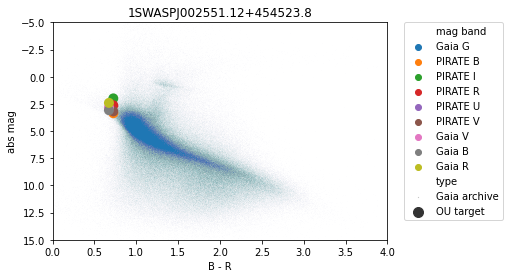

1SWASPJ002552.75+454445.3


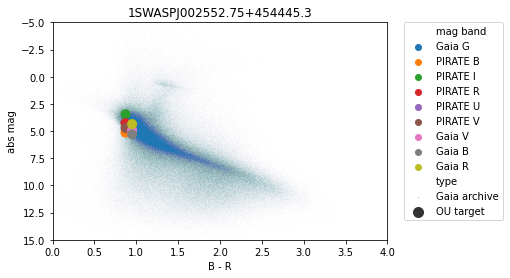

1SWASPJ002552.88+454558.7


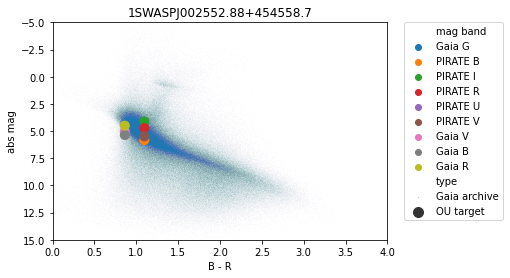

1SWASPJ184559.85+471858.4


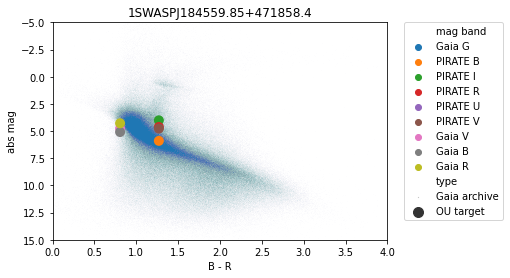

HD38451


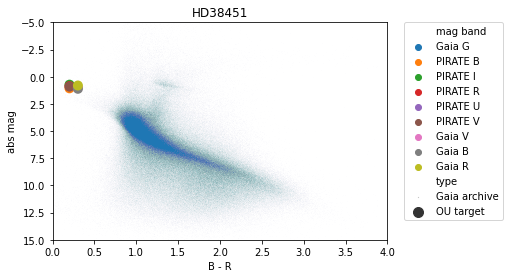

In [6]:
for target, group in df.groupby('target'):
    print(target)
    cmd = seaborn.scatterplot(
        data=pandas.concat([
            gaia.to_pandas(),
            group,
        ]),
        x='B - R',
        y='abs mag',
        hue='mag band',
        size='type',
        sizes={'OU target': 100, 'Gaia archive': 0.01},
    )
    cmd.set(title=target)
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pyplot.ylim((-5, 15))
    pyplot.xlim((0, 4))
    cmd.invert_yaxis()
    pyplot.show()

(-2.0, 4.0)

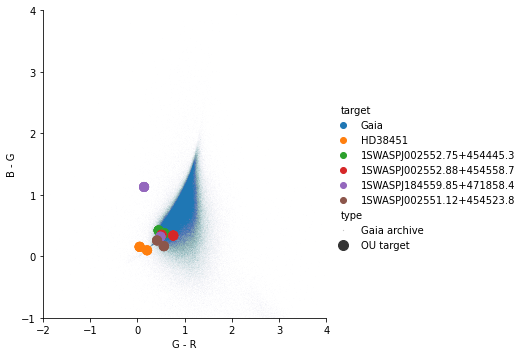

In [7]:
seaborn.relplot(
    data=pandas.concat([
            gaia.to_pandas(),
            df,
        ]),
    x='G - R',
    y='B - G',
    hue='target',
    size='type',
    sizes={'OU target': 100, 'Gaia archive': 0.01},
)
pyplot.ylim((-1, 4))
pyplot.xlim((-2, 4))